In [1]:
using FFTW, LinearAlgebra
using Plots
gr()

Plots.GRBackend()

In [20]:
include("micmac2.jl")

test/donnees_data3_128_micmac/donnee_0_1.txt
6.951395002670793
1.167514867882035e-7


(Complex{Float64}[-1.30466-0.548538im, -1.17318-0.49937im, -1.03205-0.443756im, -0.882849-0.381956im, -0.727054-0.314456im, -0.566052-0.241973im, -0.401114-0.165436im, -0.233404-0.0859609im, -0.0640035-0.00479851im, 0.106051+0.0767148im  …  -1.78202-0.719327im, -1.81678-0.725734im, -1.83224-0.726979im, -1.82823-0.723242im, -1.80491-0.714579im, -1.76276-0.700909im, -1.70255-0.682037im, -1.62531-0.657679im, -1.53229-0.627508im, -1.4249-0.59121im], Complex{Float64}[-0.548538+1.30466im, -0.59121+1.4249im, -0.627508+1.53229im, -0.657679+1.62531im, -0.682037+1.70255im, -0.700909+1.76276im, -0.714579+1.80491im, -0.723242+1.82823im, -0.726979+1.83224im, -0.725734+1.81678im  …  0.157218-0.27572im, 0.0767148-0.106051im, -0.00479851+0.0640035im, -0.0859609+0.233404im, -0.165436+0.401114im, -0.241973+0.566052im, -0.314456+0.727054im, -0.381956+0.882849im, -0.443756+1.03205im, -0.49937+1.17318im])

  0.695721 seconds (804.00 k allocations: 1.217 GiB, 25.27% gc time)
test/donnees_data3_128_micmac/donnee_0_1.txt
6.951395002670793
1.167514867882035e-7


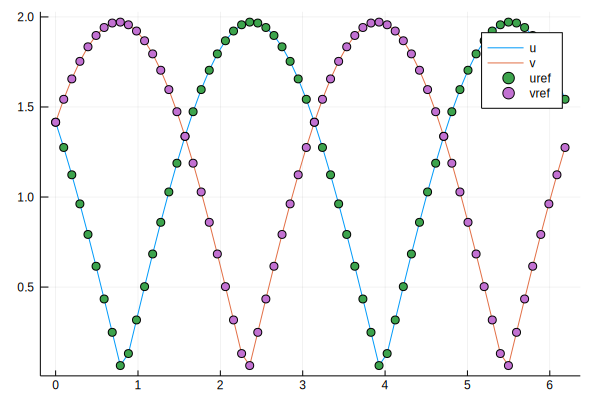

In [21]:
xmin     = 0
xmax     = 2π
T        = 2π
nx       = 64
ntau     = 32
tfinal   = 0.25
epsilon  = 0.1

data = DataSet(xmin, xmax, nx, epsilon, T, tfinal)

dt = 2.0^(-3) * tfinal / 16

m = MicMac(data, ntau)

@time u, v = run(m, dt)

uref, vref = compute_error(u, v, data)

plot(data.x, abs.(u), label=:u)
plot!(data.x, abs.(v), label=:v)
scatter!(data.x, abs.(uref), label=:uref)
scatter!(data.x, abs.(vref), label=:vref)